In [1]:
from itertools import product

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

import tensorflow_datasets as tfds

from src.models.layers import ECHConv2D

np.set_printoptions(precision=2, linewidth=150)


In [61]:
IMAGE_SHAPE = (129, 129)


In [62]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


In [63]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


@tf.function
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], IMAGE_SHAPE)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], IMAGE_SHAPE)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def random_rotate_image(image, label):
    # rotation = np.random.uniform(-180,180)
    rotation = 90
    image = rotate(image, rotation, reshape=False, order=1)
    label = rotate(label, rotation, reshape=False, order=1)
    return image, label, rotation


def tf_random_rotate_image(image, label):
    im_shape = image.shape
    label_shape = label.shape
    [
        image, label, rotation
    ] = tf.py_function(
        random_rotate_image,
        [image, label],
        [tf.float32, tf.float32, tf.float32],
    )
    image.set_shape(im_shape)
    label.set_shape(label_shape)
    return image, label, rotation


In [64]:
train = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image)

train_rotated = train.map(tf_random_rotate_image, num_parallel_calls=tf.data.AUTOTUNE)
test_rotated = test.map(tf_random_rotate_image)

In [65]:
train_dataset = train.batch(64)
test_dataset = test.batch(64)

train_dataset_rotated = train_rotated.batch(64)
test_dataset_rotated = test_rotated.batch(64)

In [66]:
sample_batch, sample_batch_mask = next(train_dataset.as_numpy_iterator())
sample_batch_rotated, sample_batch_mask_rotated, rotation = next(train_dataset_rotated.as_numpy_iterator())

In [67]:
rotation

array([90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90.,
       90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90.,
       90., 90., 90., 90., 90., 90., 90., 90.], dtype=float32)

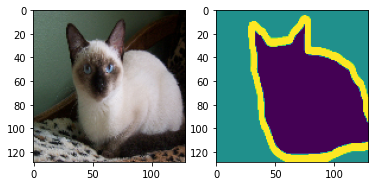

In [68]:
plt.subplot(121)
plt.imshow(sample_batch[3,:,:,:])
plt.subplot(122)
plt.imshow(sample_batch_mask[3,:,:,:])

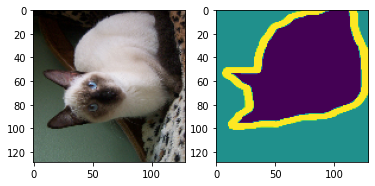

In [69]:
plt.subplot(121)
plt.imshow(sample_batch_rotated[3,:,:,:])
plt.subplot(122)
plt.imshow(sample_batch_mask_rotated[3,:,:,:])

In [70]:
np.max(sample_batch_rotated)

1.0

In [71]:
layer = ECHConv2D(1, 9, initializer=tf.keras.initializers.Constant(1.0))

In [72]:
atoms0, atoms = layer.conv_ch.atoms

In [73]:
atoms.shape

(9, 9, 1, 1, 4, 12)

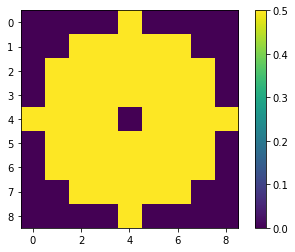

In [74]:
plt.imshow(np.real(np.sum(atoms, axis=-1)[:,:,0,0,0]))
plt.colorbar()

In [75]:
y = layer(sample_batch)
y_rotated = layer(sample_batch_rotated)

In [82]:
radius = 121 // 2
x_grid = np.arange(-radius, radius+1 , 1)
x_coord, y_coord = np.meshgrid(x_grid, x_grid)
r = np.sqrt(x_coord**2 + y_coord**2)
mask = (r < radius-1)


In [87]:
b = 5
c_out = 1

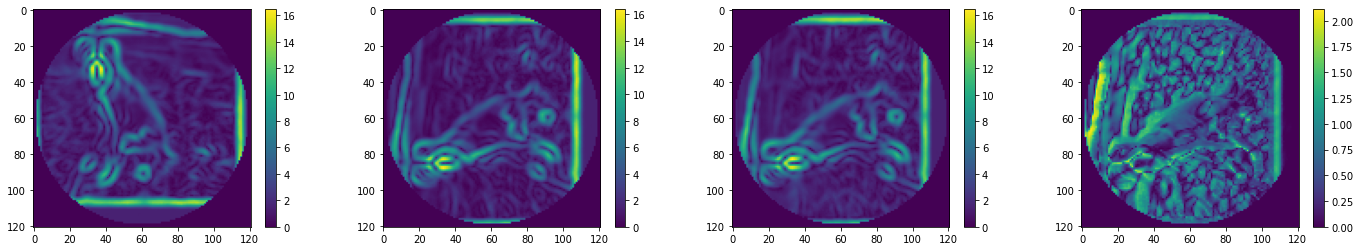

In [88]:
plt.figure(figsize=(24, 4))
plt.subplot(141)
plt.imshow(y.numpy()[b, :, :, c_out] * mask)
plt.colorbar()
plt.subplot(142)
plt.imshow(y_rotated.numpy()[b, :, :, c_out] * mask)
plt.colorbar()
plt.subplot(143)
feature_map_rotated = rotate(y.numpy()[b, :, :, c_out],
                             rotation[b],
                             order=1,
                             reshape=False)
plt.imshow(feature_map_rotated * mask)
plt.colorbar()
plt.subplot(144)
plt.imshow(np.abs(y_rotated.numpy()[b, :, :, c_out] * mask -
           feature_map_rotated * mask))
plt.colorbar()

In [37]:
filters = np.squeeze(layer.conv_ch.filters.numpy())
np.real(filters[:,:,0,2])



array([[ 0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00, -5.00e-01,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00],
       [ 0.00e+00,  0.00e+00, -1.92e-01, -4.00e-01, -5.00e-01, -4.00e-01, -1.92e-01,  0.00e+00,  0.00e+00],
       [ 0.00e+00,  1.92e-01, -9.18e-17, -3.00e-01, -5.00e-01, -3.00e-01,  3.06e-17,  1.92e-01,  0.00e+00],
       [ 0.00e+00,  4.00e-01,  3.00e-01, -9.18e-17, -5.00e-01,  3.06e-17,  3.00e-01,  4.00e-01,  0.00e+00],
       [ 5.00e-01,  5.00e-01,  5.00e-01,  5.00e-01,  5.00e-01,  5.00e-01,  5.00e-01,  5.00e-01,  5.00e-01],
       [ 0.00e+00,  4.00e-01,  3.00e-01, -9.18e-17, -5.00e-01,  3.06e-17,  3.00e-01,  4.00e-01,  0.00e+00],
       [ 0.00e+00,  1.92e-01, -9.18e-17, -3.00e-01, -5.00e-01, -3.00e-01,  3.06e-17,  1.92e-01,  0.00e+00],
       [ 0.00e+00,  0.00e+00, -1.92e-01, -4.00e-01, -5.00e-01, -4.00e-01, -1.92e-01,  0.00e+00,  0.00e+00],
       [ 0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00, -5.00e-01,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00]], dtype=float32)